# Multitask Learning for Geometric Shape Classification and Counting
## Deep Neural Networks, Homework 1
### Krzysztof Hałubek

## Setup

### Imports

In [1]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.backends.cudnn as cudnn
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import copy
import matplotlib.pyplot as plt

### Setting seeds and getting deterministic behaviour

In [2]:
# Seed everything.
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Deterministic generator for DataLoader shuffle
dg = torch.Generator().manual_seed(seed)

### Downloading the dataset

In [3]:
!rm -rf data

!wget https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null

!rm data_gsn.zip

--2025-11-24 18:47:05--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-24 18:47:06--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.06s   

2025-11-24 18:47:06 (93.5 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



### Simple helper functions used both in EDA and experiments

In [4]:
# Precompute pairs (0..5 choose 2).
pairs = [(i, j) for i in range(6) for j in range(i+1, 6)]

# Map each pair to a unique index for classification.
pair_to_idx = {p: i for i, p in enumerate(pairs)}

def counts_to_class(counts):
  """
  Converts 6 shape counts into an integer in [0, 134]
  representing one of the 135 configuration classes.
  """

  # Indices of shapes that apear.
  shapes = [i for i, c in enumerate(counts) if c > 0]
  assert len(shapes) == 2, f"Expected exactly 2 shapes per image, got {shapes}."

  i, j = shapes
  pair_idx = pair_to_idx[(i, j)]

  # Count of first shape (1..9), implicates count of other shape,
  # so only one is neccessary, but we still check conditions.
  count_i = counts[i]
  count_j = counts[j]
  assert 1 <= count_i <= 9, f"Invalid count ({count_i}) of shape {i}."
  assert 1 <= count_j <= 9, f"Invalid count ({count_j}) of shape {j}."
  assert count_i + count_j == 10, f"Invalid counts: {count_i} and {count_j} of shapes."

  # Return global class index.
  return pair_idx * 9 + (count_i - 1)

def class_to_pair(class_idx):
  """
  Converts integer in [0, 134] representing one of the 135
  configuration classes into a pair of indices representing shapes.
  """

  assert 0 <= class_idx < 135, f"Invalid class index: {class_idx}."

  return pairs[class_idx // 9]

## Exploratory Dataset Analysis (EDA)

In [5]:
df = pd.read_csv("data/labels.csv")
shape_cols = ["squares", "circles", "up", "right", "down", "left"]
df["class"] = df[shape_cols].apply(counts_to_class, axis=1)

/tmp/ipython-input-1336083362.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count_i = counts[i]
/tmp/ipython-input-1336083362.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count_j = counts[j]


### Plot the counts of each shape across the whole dataset

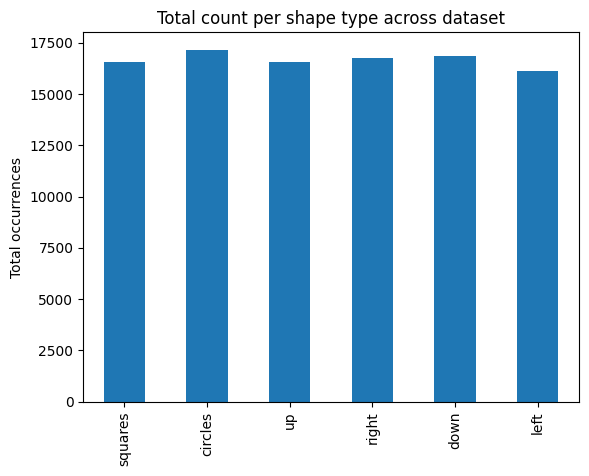

In [6]:
df[shape_cols].sum().plot(kind="bar")
plt.title("Total count per shape type across dataset")
plt.ylabel("Total occurrences")
plt.show()

### Calculate class frequencies statistics

In [9]:
# Count how many times each class appears.
class_counts = df["class"].value_counts().reindex(range(135), fill_value=0)

# Compute summary statistics
min_count = class_counts.min()
max_count = class_counts.max()
mean_count = class_counts.mean()
no_sample = (class_counts == 0).sum()

# Print in LaTeX-ready format.
print("\\begin{tabular}{l r}")
print("\\hline")
print("Statistic & Value \\\\")
print("\\hline")
print(f"Minimum class frequency & {min_count} \\\\")
print(f"Maximum class frequency & {max_count} \\\\")
print(f"Mean class frequency & {mean_count:.1f} \\\\")
print(f"Classes with 0 samples & {no_sample} \\\\")
print("\\hline")
print("\\end{tabular}")

\begin{tabular}{l r}
\hline
Statistic & Value \\
\hline
Minimum class frequency & 0 \\
Maximum class frequency & 120 \\
Mean class frequency & 74.1 \\
Classes with 0 samples & 30 \\
\hline
\end{tabular}


### Visualize a few random samples from the dataset

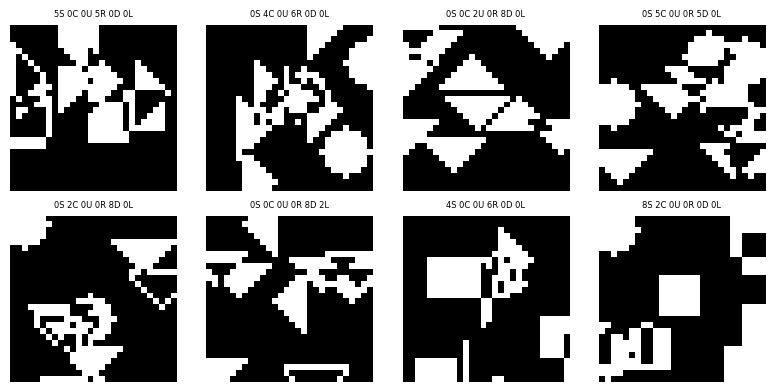

In [ ]:
# Set figure and axes up and draw random sample.
fig, axes = plt.subplots(2, 4, figsize=(8,4))
indices = random.sample(range(len(df)), 8)

for ax, idx in zip(axes.flatten(), indices):

    # Get the image.
    row = df.iloc[idx]
    img = Image.open(f"data/{row['name']}")
    ax.imshow(img, cmap="gray")

    # Create simple text label
    label_txt = f"{row['squares']}S {row['circles']}C {row['up']}U {row['right']}R {row['down']}D {row['left']}L"
    ax.set_title(label_txt, fontsize=6)
    ax.axis("off")

# Plot the images.
plt.tight_layout()
plt.show()

## Defining datasets, model, and helper functions for the experiments

### Custom **PyTorch** `DataSet` **Class**

In [ ]:
class GSNDataset(Dataset):
  def __init__(self, csv_path, img_dir, transform=None, augment=False, split="all"):
    """
    PyTorch Dataset for the Geometric Shape Numbers (GSN) dataset.

    Args:
        csv_path (str): Path to labels.csv
        img_dir (str): Directory containing .png images
        transform (callable, optional): torchvision transforms to apply
        augment (bool): Whether to apply custom augmentations (rotation, noise, etc.)
        split (str): Which subset to use. Options:
          - "train": first 9000 samples
          - "val": last 1000 samples
          - "all": entire dataset
          Default set to "all".
    """

    # Load the CSV into a pandas DataFrame.
    self.df = pd.read_csv(csv_path)
    self.img_dir = img_dir
    self.transform = transform
    self.augment = augment

    # Define the slices for each split.
    splits = {
      "train": slice(0, 9000),
      "val": slice(9000, 10000),
      "all": slice(0, len(self.df))
    }

    # Validate the split argument.
    if split not in splits:
      raise ValueError("split must be 'train', 'val', or 'all'")

    # Keep only the rows corresponding to the selected split.
    self.df = self.df.iloc[splits[split]].reset_index(drop=True)

  def __len__(self):
    return len(self.df)

  def _flip_counts(self, counts, horizontal=False, vertical=False):
    """
    Helper function to fix triangle orientation counts when flipping image.
    """

    counts = counts.copy()
    up, right, down, left = counts[2:6]

    if horizontal:
      right, left = left, right

    if vertical:
      up, down = down, up

    counts[2:6] = [up, right, down, left]
    return counts

  def _rotate_counts(self, counts, k):
    """
    Helper function to fix triangle orientation counts
    when rotating the image by (k * 90 degrees) clockwise.
    """

    counts = counts.copy()

    for _ in range(k):
      counts = [
          counts[0], # squares
          counts[1], # circles
          counts[5], # up <- left
          counts[2], # right <- up
          counts[3], # down <- right
          counts[4], # left <- down
      ]

    return counts

  def _apply_random_augment(self, img, counts):
    """
    Apply random augmentations:
      - horizontal/vertical flip
      - 90 degree rotations
    Fix orientation labels if neccessary.
    """

    # Random horizontal flip.
    if random.random() < 0.5:
      img = transforms.functional.hflip(img)
      counts = self._flip_counts(counts, horizontal=True)

    # Random vertical flip.
    if random.random() < 0.5:
      img = transforms.functional.vflip(img)
      counts = self._flip_counts(counts, vertical=True)

    # Random 90 degree rotations.
    k = random.choice([0, 1, 2, 3])
    img = transforms.functional.rotate(img, k * -90)
    counts = self._rotate_counts(counts, k)

    return img, counts

  def __getitem__(self, idx):
    """
    Returns a dictionary with:
      image: tensor (1,H,W) in [0,1]
      counts: tensor (6,) of floats for regression head
      class: scalar int for classification head
    """

    row = self.df.iloc[idx]

    # Get image.
    img_path = os.path.join(self.img_dir, row["name"])
    img = Image.open(img_path).convert("L")

    # Get counts.
    counts = row[1:].values.astype(int).tolist()

    # Apply optional augmentations.
    if self.augment:
      img, counts = self._apply_random_augment(img, counts)

    # torchvision transforms.
    if self.transform:
      img = self.transform(img)
    else:
      img = transforms.ToTensor()(img)

    # Convert to tensors.
    counts_tensor = torch.tensor(counts, dtype=torch.float32)
    class_idx = counts_to_class(counts)

    return {
        "image": img,
        "counts": counts_tensor,
        "class": class_idx
    }

### Custom **Multi-Headed Net**

In [ ]:
class MultiHeadGSNNet(nn.Module):
  """
  Multi-head neural network for the Geometric Shape Numbers (GSN) dataset.
  Returns two outputs:
    log_probs: tensor (batch_size, 135) of log probabilities for classification head
    counts: tensor (batch_size, 6) of shape counts for regression head
  """

  def __init__(self):
    super().__init__()

    # Shared feature extractor.
    self.feature_extractor = nn.Sequential(
      nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
      nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
      nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
      nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
      nn.Flatten(start_dim=1),
      nn.Linear(64 * 28 * 28, 256), nn.ReLU()
    )


    # Classification head
    self.head_cls = nn.Sequential(
        nn.Linear(256, 128), nn.ReLU(),
        nn.Linear(128, 135), nn.LogSoftmax(dim=1)
    )

    # Regression head
    self.head_cnt = nn.Sequential(
        nn.Linear(256, 128), nn.ReLU(),
        nn.Linear(128, 6)
    )

  def forward(self, x):
    features = self.feature_extractor(x)

    log_probs = self.head_cls(features)
    counts = self.head_cnt(features)

    return log_probs, counts

### Helper function to compute metrics

In [ ]:
def compute_metrics(log_probs, counts_pred, labels):
  """
  Simple helper function to compute classification and regression metrics.
  """

  # Classification.
  cls_pred = torch.argmax(log_probs, dim=1).cpu().numpy()
  cls_true = labels["class"].cpu().numpy()
  top1_acc = (cls_pred == cls_true).mean()
  f1 = f1_score(cls_true, cls_pred, average="macro")

  # Per-pair accuracy.
  pred_pairs = [class_to_pair(c) for c in cls_pred]
  true_pairs = [class_to_pair(c) for c in cls_true]
  per_pair_acc = np.mean([p == t for p, t in zip(pred_pairs, true_pairs)])

  # Regression.
  cnt_pred = counts_pred.cpu().detach().numpy()
  cnt_true = labels["counts"].cpu().numpy()
  rmse_per_class = np.sqrt(np.mean((cnt_pred - cnt_true) ** 2, axis=0))
  mae_per_class = np.mean(np.abs(cnt_pred - cnt_true), axis=0)
  rmse_overall = np.sqrt(np.mean((cnt_pred - cnt_true) ** 2))
  mae_overall = np.mean(np.abs(cnt_pred - cnt_true))

  # Return all metrics in a dictionary.
  return {
      "top1_acc": top1_acc,
      "f1_score": f1,
      "per_pair_acc": per_pair_acc,
      "rmse_per_class": rmse_per_class,
      "mae_per_class": mae_per_class,
      "rmse_overall": rmse_overall,
      "mae_overall": mae_overall
  }

### Helper function to print epoch results

In [ ]:
def print_metrics(epoch, train_loss, val_loss, metrics):
  """
  Simple helper function to print epoch results to the console
  in a pretty manner.
  """

  # Format per-class metrics.
  rmse_str = ", ".join([f"{x:.3f}" for x in metrics['rmse_per_class']])
  mae_str = ", ".join([f"{x:.3f}" for x in metrics['mae_per_class']])

  # Prepare lines to print.
  lines = [
      f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}",
      "Validation Metrics:",
      f"Top1 Acc: {metrics['top1_acc']:.3f} | Macro F1: {metrics['f1_score']:.3f} | Per-pair Acc: {metrics['per_pair_acc']:.3f}",
      f"Overall RMSE: {metrics['rmse_overall']:.3f} | Overall MAE: {metrics['mae_overall']:.3f}",
      f"Per-class RMSE: {rmse_str}",
      f"Per-class MAE:  {mae_str}",
  ]

  # Determine box width.
  width = max(len(line) for line in lines) + 4

  # Print top border.
  epoch_str = f" Epoch {epoch} "
  left_length = (width - 2 - len(epoch_str)) // 2
  right_length = width - 2 - len(epoch_str) - left_length
  top_border = "╔" + "═" * left_length + epoch_str + "═" * right_length + "╗"
  print(top_border)

  # Print lines.
  for line in lines:
      print(f"║ {line.ljust(width - 4)} ║")

  # Print bottom border.
  print("╚" + "═" * (width - 2) + "╝")
  print("\n")

### Helper function to plot results

In [ ]:
def plot_results(train_losses, val_losses, val_top1_acc, val_rmse):
  """
  Helper function to plot training and validation losses as well as
  validation accuracy and RMSE with respect to epochs using matplotlib.
  """

  # Initialize plot.
  plt.figure(figsize=(12, 5))

  # Losses.
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Train Loss")
  plt.plot(val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training & Validation Loss")
  plt.legend()


  # Accuracy.
  plt.subplot(2, 2, 2)
  plt.plot(val_top1_acc, label="Validation Top1 Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Validation Accuracy")
  plt.legend()

  # RMSE.
  plt.subplot(2, 2, 4)
  plt.plot(val_rmse, label="Validation RMSE")
  plt.xlabel("Epoch")
  plt.ylabel("RMSE")
  plt.title("Validation RMSE")
  plt.legend()

  # Show plots.
  plt.tight_layout()
  plt.show()

## Main reproducible experiment logic

In [ ]:
def run_experiment(
    train_loader,
    val_loader,
    cls_loss,
    cnt_loss,
    device,
    lambda_cnt,
    cls_on=True,
    reg_on=True,
    epochs=100,
    patience=20
  ):
  """
  Run a single experiment according to given parameters.
  Trains the network using Adam optimizer with learning rate 1e-3.
  Logs metrics and returns a dictionary with total metrics summary.
  Utilizes early stopping.
  """

  # Create a new model for this experiment.
  model = MultiHeadGSNNet().to(device)

  # Optimizer.
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  # Track metrics per epoch.
  train_losses, val_losses, metrics_history = [], [], []

  # Early stopping variables.
  best_val_loss = float("inf")
  best_model_weights = copy.deepcopy(model.state_dict())
  best_epoch = -1

  # Training loop.
  for epoch in range(epochs):
    # Set model to training mode and reset batch loss accumulator.
    model.train()
    running_loss = 0.0

    # Iterate over batches.
    for batch in train_loader:

      # Reset gradient and get batch data.
      optimizer.zero_grad()
      images = batch["image"].to(device)
      counts_true = batch["counts"].to(device)
      class_true = batch["class"].to(device)

      # Get model output.
      log_probs, counts_pred = model(images)

      # Compute batch training losses based on experiment setting.
      loss_cls = cls_loss(log_probs, class_true) if cls_on else torch.tensor(0., device=device)
      loss_cnt = cnt_loss(counts_pred, counts_true) if reg_on else torch.tensor(0., device=device)

      # Total loss calculations.
      loss = loss_cls + lambda_cnt * loss_cnt
      loss.backward()
      optimizer.step()

      # Sum up batch losses.
      running_loss += loss.item() * images.size(0)

    # Calculate final training loss.
    train_loss = running_loss / len(train_loader.dataset)

    # Validation.
    model.eval()
    val_running_loss = 0.0

    # Accumulate ground truths and model predictions across batches.
    all_labels = {"class": [], "counts": []}
    all_preds = {"class": [], "counts": []}

    with torch.no_grad():

      # Iterate over batches.
      for batch in val_loader:

        # Get batch data.
        images = batch["image"].to(device)
        counts_true = batch["counts"].to(device)
        class_true = batch["class"].to(device)

        # Get model output.
        log_probs, counts_pred = model(images)

        # Compute batch validation losses based on experiment setting.
        loss_cls = cls_loss(log_probs, class_true) if cls_on else torch.tensor(0., device=device)
        loss_cnt = cnt_loss(counts_pred, counts_true) if reg_on else torch.tensor(0., device=device)

        # Calculate total loss and sum it up across batches.
        val_loss = loss_cls + lambda_cnt * loss_cnt
        val_running_loss += val_loss.item() * images.size(0)

        # Append ground truths and predictions for this batch.
        all_labels["class"].append(class_true)
        all_labels["counts"].append(counts_true)
        all_preds["class"].append(log_probs)
        all_preds["counts"].append(counts_pred)

    # Calculate final validation loss.
    val_loss = val_running_loss / len(val_loader.dataset)

    # Concatenate all batches into full validation tensors for metric computation.
    all_labels["class"] = torch.cat(all_labels["class"])
    all_labels["counts"] = torch.cat(all_labels["counts"])
    all_preds["class"] = torch.cat(all_preds["class"])
    all_preds["counts"] = torch.cat(all_preds["counts"])

    # Calculate and print epoch metrics.
    metrics = compute_metrics(all_preds["class"], all_preds["counts"], all_labels)
    print_metrics(epoch + 1, train_loss, val_loss, metrics)

    # Append statistics.
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    metrics_history.append(metrics)

    # Early stopping.
    # Update best model if validation improves; otherwise check patience window.
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model_weights = copy.deepcopy(model.state_dict())
      best_epoch = epoch
    else:
      if epoch - best_epoch >= patience:
        print("Early stopping triggered.")
        break

  # Extract per-epoch metrics from metrics_history for plotting.
  val_top1_acc = [m["top1_acc"] for m in metrics_history]
  val_rmse = [m["rmse_overall"] for m in metrics_history]

  # Plot the results of the experiment.
  plot_results(train_losses, val_losses, val_top1_acc, val_rmse)

  # Restore best weights.
  model.load_state_dict(best_model_weights)

  # Return the complete statistical history and the best model.
  return {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "metrics_history": metrics_history,
    "model": model,
    "epoch": best_epoch
  }

## Running the experiments

### Set device to cuda if available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


### Declare invariant base values

In [ ]:
# Transform for all images (convert to tensor).
transform = transforms.Compose([
    transforms.ToTensor()
])

# Datasets.
train_dataset = GSNDataset("data/labels.csv", "data/", transform=transform, augment=True, split="train")
val_dataset = GSNDataset("data/labels.csv", "data/", transform=transform, augment=False, split="val")

# DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=dg, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False, num_workers=0)

# General losses.
cls_loss = nn.NLLLoss()       # Classification.
cnt_loss = nn.SmoothL1Loss()  # Regression.

### Classification-only experiment

╔════════════════════════ Epoch 1 ═════════════════════════╗
║ Train Loss: 4.7230 | Val Loss: 4.6742                    ║
║ Validation Metrics:                                      ║
║ Top1 Acc: 0.013 | Macro F1: 0.000 | Per-pair Acc: 0.075  ║
║ Overall RMSE: 3.199 | Overall MAE: 1.842                 ║
║ Per-class RMSE: 3.083, 3.336, 3.386, 3.138, 3.186, 3.049 ║
║ Per-class MAE:  1.662, 2.072, 2.093, 1.729, 1.843, 1.652 ║
╚══════════════════════════════════════════════════════════╝


╔════════════════════════ Epoch 2 ═════════════════════════╗
║ Train Loss: 4.3909 | Val Loss: 3.9377                    ║
║ Validation Metrics:                                      ║
║ Top1 Acc: 0.047 | Macro F1: 0.009 | Per-pair Acc: 0.170  ║
║ Overall RMSE: 3.298 | Overall MAE: 2.090                 ║
║ Per-class RMSE: 3.169, 3.594, 3.552, 2.998, 3.291, 3.142 ║
║ Per-class MAE:  1.869, 2.469, 2.587, 1.767, 2.045, 1.806 ║
╚══════════════════════════════════════════════════════════╝


╔═══════════════════

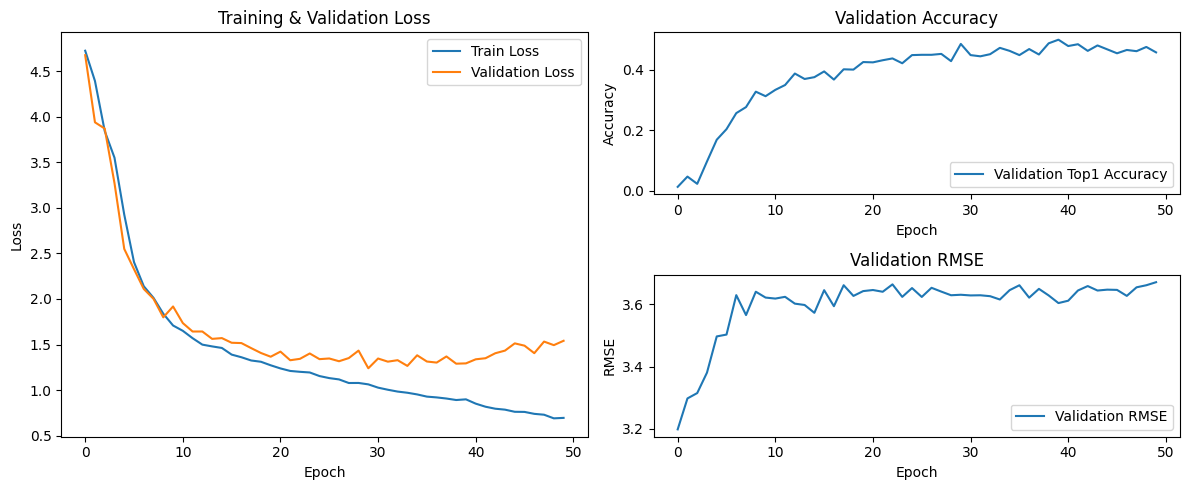

Best Classification-only model found:
╔════════════════════════ Epoch 29 ════════════════════════╗
║ Train Loss: 1.0634 | Val Loss: 1.2398                    ║
║ Validation Metrics:                                      ║
║ Top1 Acc: 0.486 | Macro F1: 0.443 | Per-pair Acc: 0.941  ║
║ Overall RMSE: 3.630 | Overall MAE: 2.465                 ║
║ Per-class RMSE: 3.103, 4.128, 3.842, 3.176, 3.662, 3.762 ║
║ Per-class MAE:  2.033, 2.596, 2.897, 2.041, 2.655, 2.568 ║
╚══════════════════════════════════════════════════════════╝




In [ ]:
# Run the experiment with proper parameters.
cls_only = run_experiment(train_loader, val_loader,
                      cls_loss, cnt_loss, device,
                      lambda_cnt=0.0, cls_on=True, reg_on=False)

# Extract the results.
best_epoch = cls_only["epoch"]
train_loss = cls_only["train_losses"][best_epoch]
val_loss = cls_only["val_losses"][best_epoch]
metrics = cls_only["metrics_history"][best_epoch]

# Print the statistics of the best model found.
print("Best Classification-only model found:")
print_metrics(best_epoch, train_loss, val_loss, metrics)

### Regression-only experiment

╔════════════════════════ Epoch 1 ═════════════════════════╗
║ Train Loss: 1.4104 | Val Loss: 1.3771                    ║
║ Validation Metrics:                                      ║
║ Top1 Acc: 0.009 | Macro F1: 0.000 | Per-pair Acc: 0.053  ║
║ Overall RMSE: 2.749 | Overall MAE: 1.763                 ║
║ Per-class RMSE: 2.598, 2.565, 2.869, 2.898, 2.790, 2.757 ║
║ Per-class MAE:  1.673, 1.710, 1.823, 1.867, 1.745, 1.758 ║
╚══════════════════════════════════════════════════════════╝


╔════════════════════════ Epoch 2 ═════════════════════════╗
║ Train Loss: 1.1369 | Val Loss: 0.7683                    ║
║ Validation Metrics:                                      ║
║ Top1 Acc: 0.011 | Macro F1: 0.001 | Per-pair Acc: 0.025  ║
║ Overall RMSE: 1.838 | Overall MAE: 1.095                 ║
║ Per-class RMSE: 1.170, 2.781, 1.274, 1.254, 1.258, 2.529 ║
║ Per-class MAE:  0.679, 1.733, 0.791, 0.807, 0.968, 1.590 ║
╚══════════════════════════════════════════════════════════╝


╔═══════════════════

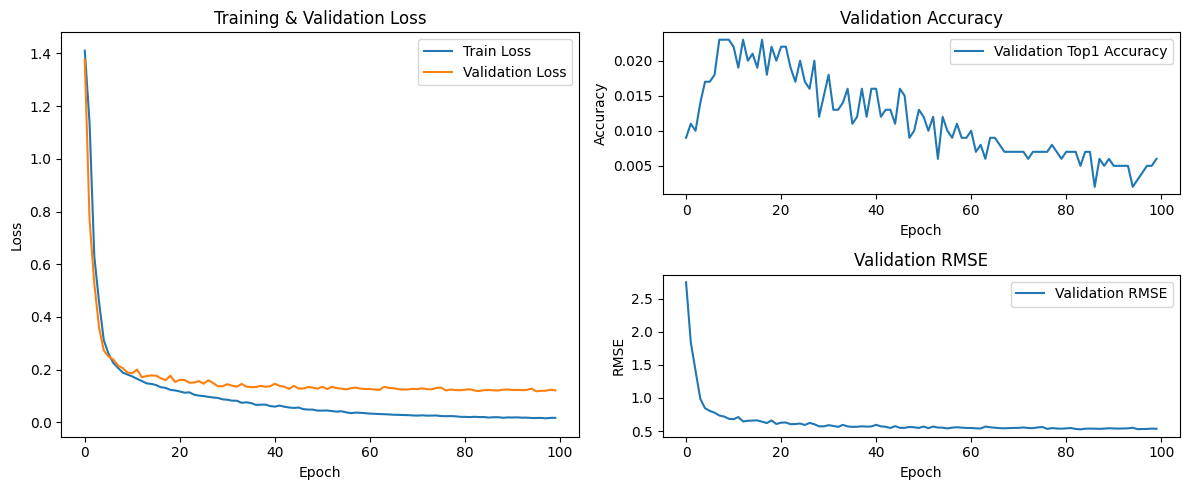

Best Regression-only model found:
╔════════════════════════ Epoch 95 ════════════════════════╗
║ Train Loss: 0.0167 | Val Loss: 0.1183                    ║
║ Validation Metrics:                                      ║
║ Top1 Acc: 0.003 | Macro F1: 0.001 | Per-pair Acc: 0.032  ║
║ Overall RMSE: 0.528 | Overall MAE: 0.286                 ║
║ Per-class RMSE: 0.447, 0.515, 0.545, 0.523, 0.551, 0.580 ║
║ Per-class MAE:  0.237, 0.277, 0.290, 0.282, 0.302, 0.329 ║
╚══════════════════════════════════════════════════════════╝




In [ ]:
# Run the experiment with proper parameters.
reg_only = run_experiment(train_loader, val_loader,
                      cls_loss, cnt_loss, device,
                      lambda_cnt=1.0, cls_on=False, reg_on=True)

# Extract the results.
best_epoch = reg_only["epoch"]
train_loss = reg_only["train_losses"][best_epoch]
val_loss = reg_only["val_losses"][best_epoch]
metrics = reg_only["metrics_history"][best_epoch]

# Print the statistics of the best model found.
print("Best Regression-only model found:")
print_metrics(best_epoch, train_loss, val_loss, metrics)

### Multitask experiment

╔════════════════════════ Epoch 1 ═════════════════════════╗
║ Train Loss: 12.5346 | Val Loss: 11.3849                  ║
║ Validation Metrics:                                      ║
║ Top1 Acc: 0.029 | Macro F1: 0.005 | Per-pair Acc: 0.189  ║
║ Overall RMSE: 2.509 | Overall MAE: 1.559                 ║
║ Per-class RMSE: 2.526, 2.826, 1.477, 2.720, 2.858, 2.380 ║
║ Per-class MAE:  1.792, 1.771, 0.934, 1.660, 1.754, 1.440 ║
╚══════════════════════════════════════════════════════════╝


╔════════════════════════ Epoch 2 ═════════════════════════╗
║ Train Loss: 10.1382 | Val Loss: 8.4379                   ║
║ Validation Metrics:                                      ║
║ Top1 Acc: 0.108 | Macro F1: 0.052 | Per-pair Acc: 0.367  ║
║ Overall RMSE: 2.023 | Overall MAE: 1.175                 ║
║ Per-class RMSE: 1.403, 2.678, 1.070, 1.726, 2.827, 1.814 ║
║ Per-class MAE:  0.860, 1.662, 0.677, 1.087, 1.708, 1.053 ║
╚══════════════════════════════════════════════════════════╝


╔═══════════════════

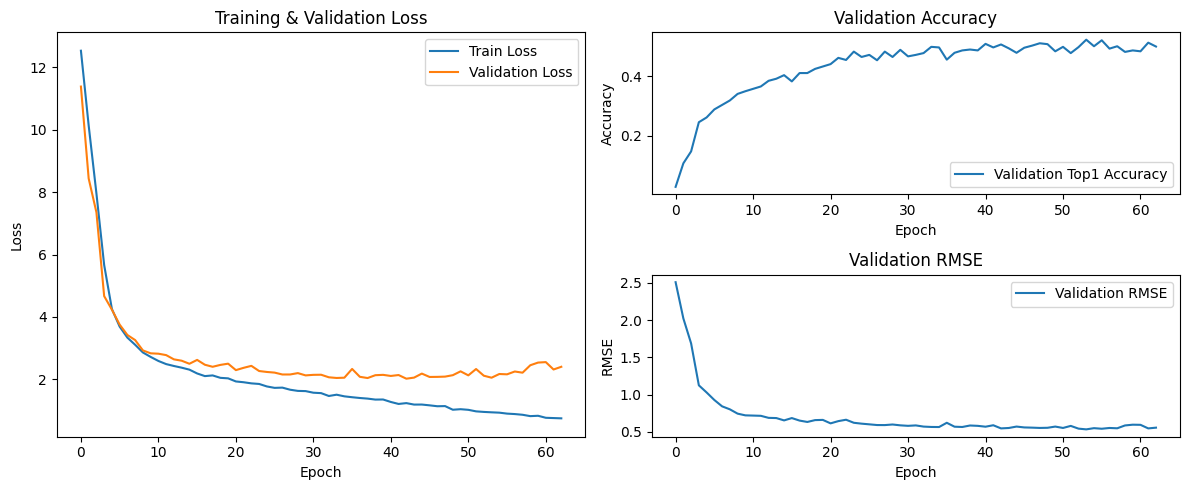

Best Multitask model found:
╔════════════════════════ Epoch 42 ════════════════════════╗
║ Train Loss: 1.2347 | Val Loss: 2.0181                    ║
║ Validation Metrics:                                      ║
║ Top1 Acc: 0.507 | Macro F1: 0.485 | Per-pair Acc: 0.954  ║
║ Overall RMSE: 0.546 | Overall MAE: 0.309                 ║
║ Per-class RMSE: 0.455, 0.476, 0.598, 0.560, 0.572, 0.595 ║
║ Per-class MAE:  0.255, 0.272, 0.321, 0.314, 0.346, 0.347 ║
╚══════════════════════════════════════════════════════════╝




In [ ]:
# Run the experiment with proper parameters.
multitask = run_experiment(train_loader, val_loader,
                      cls_loss, cnt_loss, device,
                      lambda_cnt=6, cls_on=True, reg_on=True)

# Extract the results.
best_epoch = multitask["epoch"]
train_loss = multitask["train_losses"][best_epoch]
val_loss = multitask["val_losses"][best_epoch]
metrics = multitask["metrics_history"][best_epoch]
model = multitask["model"]

# Print the statistics of the best model found.
print("Best Multitask model found:")
print_metrics(best_epoch, train_loss, val_loss, metrics)

### Plot the confusion matrix.

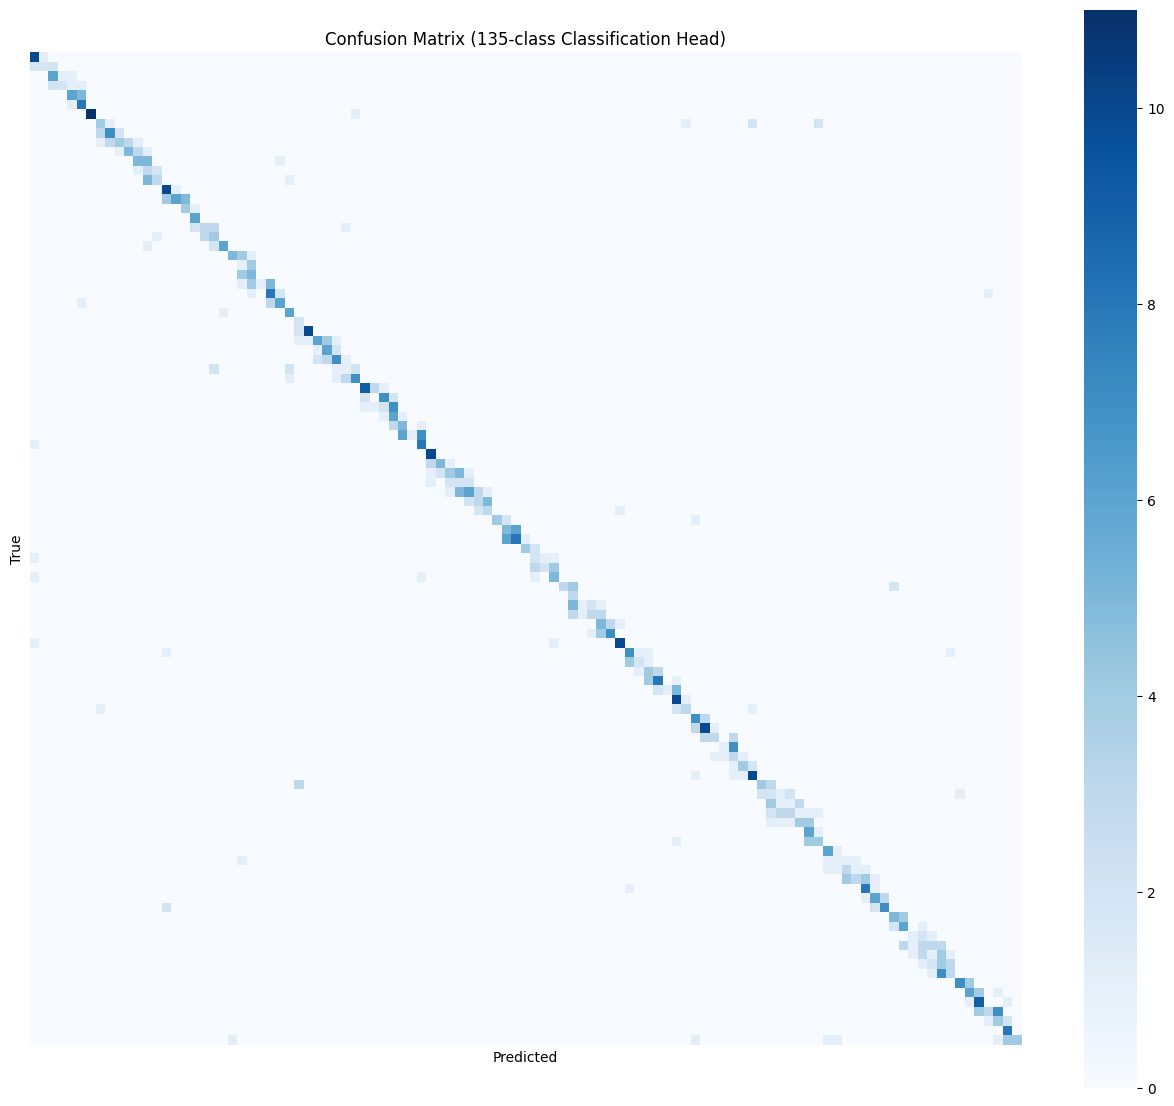

In [ ]:
model.eval()

labels_list = []
preds_list = []

with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        class_true = batch["class"].to(device)

        log_probs, _ = model(images)

        labels_list.append(class_true)
        preds_list.append(log_probs)

# Concatenate.
labels = torch.cat(labels_list)
preds = torch.cat(preds_list)

# Convert.
cls_true = labels.cpu().numpy()
cls_pred = torch.argmax(preds, dim=1).cpu().numpy()

# Confusion matrix.
cm = confusion_matrix(cls_true, cls_pred)

# Plot.
plt.figure(figsize=(16, 14))
sns.heatmap(
    cm,
    cmap="Blues",
    square=True,
    xticklabels=False,
    yticklabels=False
)
plt.title("Confusion Matrix (135-class Classification Head)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Visualize a few error examples

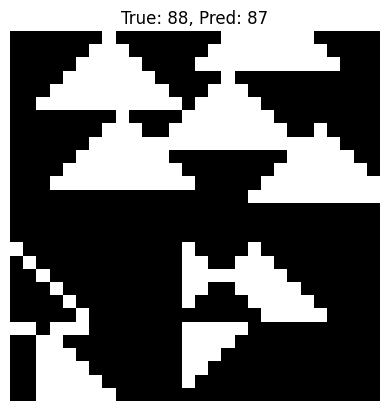

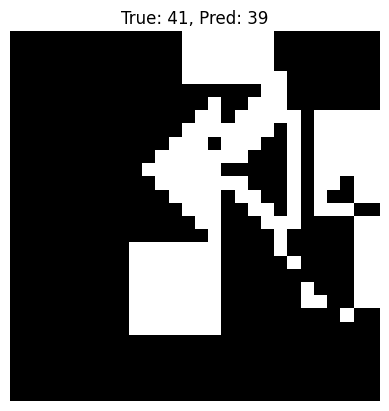

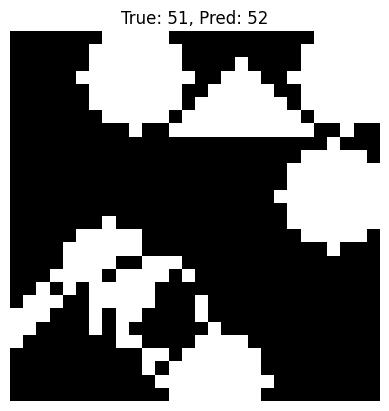

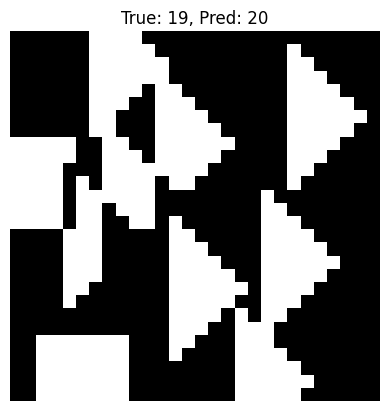

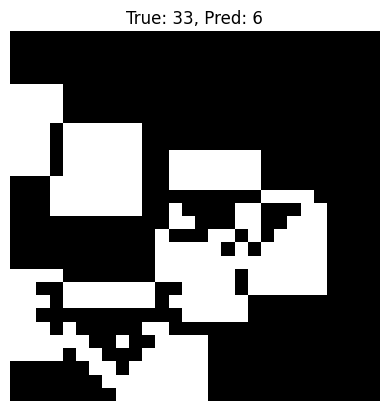

In [ ]:
mis_idx = np.where(cls_true != cls_pred)[0]

for idx in mis_idx[:5]:
    sample = val_dataset[idx]

    img = sample["image"].cpu().numpy()
    img = img.transpose(1, 2, 0)
    img = img.squeeze()

    plt.imshow(img, cmap="gray")
    plt.title(f"True: {cls_true[idx]}, Pred: {cls_pred[idx]}")
    plt.axis("off")
    plt.show()